In [15]:
from statsbombpy import sb
import pandas as pd
from mplsoccer import VerticalPitch,Pitch
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',113)

## Corner Analysis

In [6]:
def extract_coordinates(location):
    x, y = location
    return round(x, 2), round(y, 2)

def is_within_area(x, y, x1, y1, x2, y2, x3, y3, x4, y4):
    # Assuming rectangular areas where (x1, y1) is the bottom-left corner and (x3, y3) is the top-right corner
    return x1 <= x <= x3 and y3 <= y <= y1

def get_area(x, y):
    if is_within_area(x, y, 102.00, 30.00, 102.00, 18.00, 120.00, 18.00, 120.00, 30.00):
        return 'First Post'
    elif is_within_area(x, y, 102.00, 62.00, 102.00, 50.00, 120.00, 50.00, 120.00, 62.00):
        return 'Second Post'
    elif is_within_area(x, y, 114.00, 50.00, 114.00, 30.00, 120.00, 30.00, 120.00, 50.00):
        return 'Close to Goal'
    elif is_within_area(x, y, 102.00, 50.00, 102.00, 30.00, 114.00, 30.00, 114.00, 50.00):
        return 'Penalty Spot'
    else:
        return 'Out of Bounds'

In [18]:
def get_corner_analysis(country,division,season,gender,team,side,swingtype):
    events_df = sb.competition_events(
    country=country,
    division=division,
    season=season,
    gender=gender)
    
    #And to add 360 data:
    
    frames_df = sb.competition_frames(
    country=country,
    division=division,
    season=season,
    gender=gender)
    
    frames_df.rename(columns={'event_uuid': 'id'}, inplace = True)

    df_passes = events_df[events_df['type'] == 'Pass']
    df_corners = df_passes[df_passes['pass_type'] == 'Corner']

    if side == 'left' and swingtype == 'Inswinging':
        corner_coordinates = [120.0,0.1]
        swingtypecol = 'pass_inswinging'

    elif side == 'left' and swingtype == 'Outswinging':
        corner_coordinates = [120.0,0.1]
        swingtypecol = 'pass_outswinging'

    elif side == 'right' and swingtype == 'Inswinging':
        corner_coordinates = [120.0,80.0]
        swingtypecol = 'pass_inswinging'
    elif side == 'right' and swingtype == 'Outswinging':
        corner_coordinates = [120.0,80.0]
        swingtypecol = 'pass_outswinging'
    
    mask_data = (df_corners[swingtypecol] == True) & (df_corners.location.apply(lambda x: x == corner_coordinates)) & (df_corners.possession_team == team)
    df_data = df_corners.loc[mask_data,['id','location','pass_end_location','pass_angle','shot_statsbomb_xg','pass_assisted_shot_id']]
    
    df_data['start_x'] = df_data.apply(lambda x: x['location'][0],axis=1)
    df_data['start_y'] = df_data.apply(lambda x: x['location'][1],axis=1)
    df_data['end_x'] = df_data.apply(lambda x: x['pass_end_location'][0],axis=1)
    df_data['end_y'] = df_data.apply(lambda x: x['pass_end_location'][1],axis=1)

    df_data_shots = pd.DataFrame()  # Initialize an empty DataFrame

    for index, row in df_data.iterrows():
        if pd.notna(row['pass_assisted_shot_id']):  # Check if 'pass_assisted_shot_id' is not NaN
            shots = events_df[events_df['id'] == row['pass_assisted_shot_id']]
            df_data_shots = pd.concat([df_data_shots, shots], ignore_index=True)
    
    df_data_goals = df_data_shots[df_data_shots['shot_outcome'] == 'Goal']

    df_data_360 = pd.DataFrame()

    for index,row in df_data.iterrows():
        passes_360 = frames_df[frames_df['id'] == row['id']]
        df_data_360 = pd.concat([df_data_360, passes_360], ignore_index=True)

    # Apply the function to create new columns
    df_data_360[['x', 'y']] = df_data_360['location'].apply(lambda loc: pd.Series(extract_coordinates(loc)))
    df_data_360 = df_data_360[df_data_360['teammate'] == True]

    # Apply the function to determine the area for each location
    df_data_360['area'] = df_data_360.apply(lambda row: get_area(row['x'], row['y']), axis=1)
    df_data_360['PlayerInBox'] = df_data_360[df_data_360['area'] != 'Out of Bounds'].groupby('id')['area'].transform('count')
    df_data_360['PlayerInBox'] = df_data_360['PlayerInBox'].fillna(0).astype(int)

    return df_data,df_data_shots,df_data_goals,df_data_360

In [25]:
country="Germany"
division="1. Bundesliga"
season="2023/2024"
gender="male"
team = "Bayer Leverkusen"
side = "left"
swingtype = "Inswinging"
df_data,df_data_shots,df_data_goals,df_data_360 = get_corner_analysis(country,division,season,gender,team,side,swingtype)

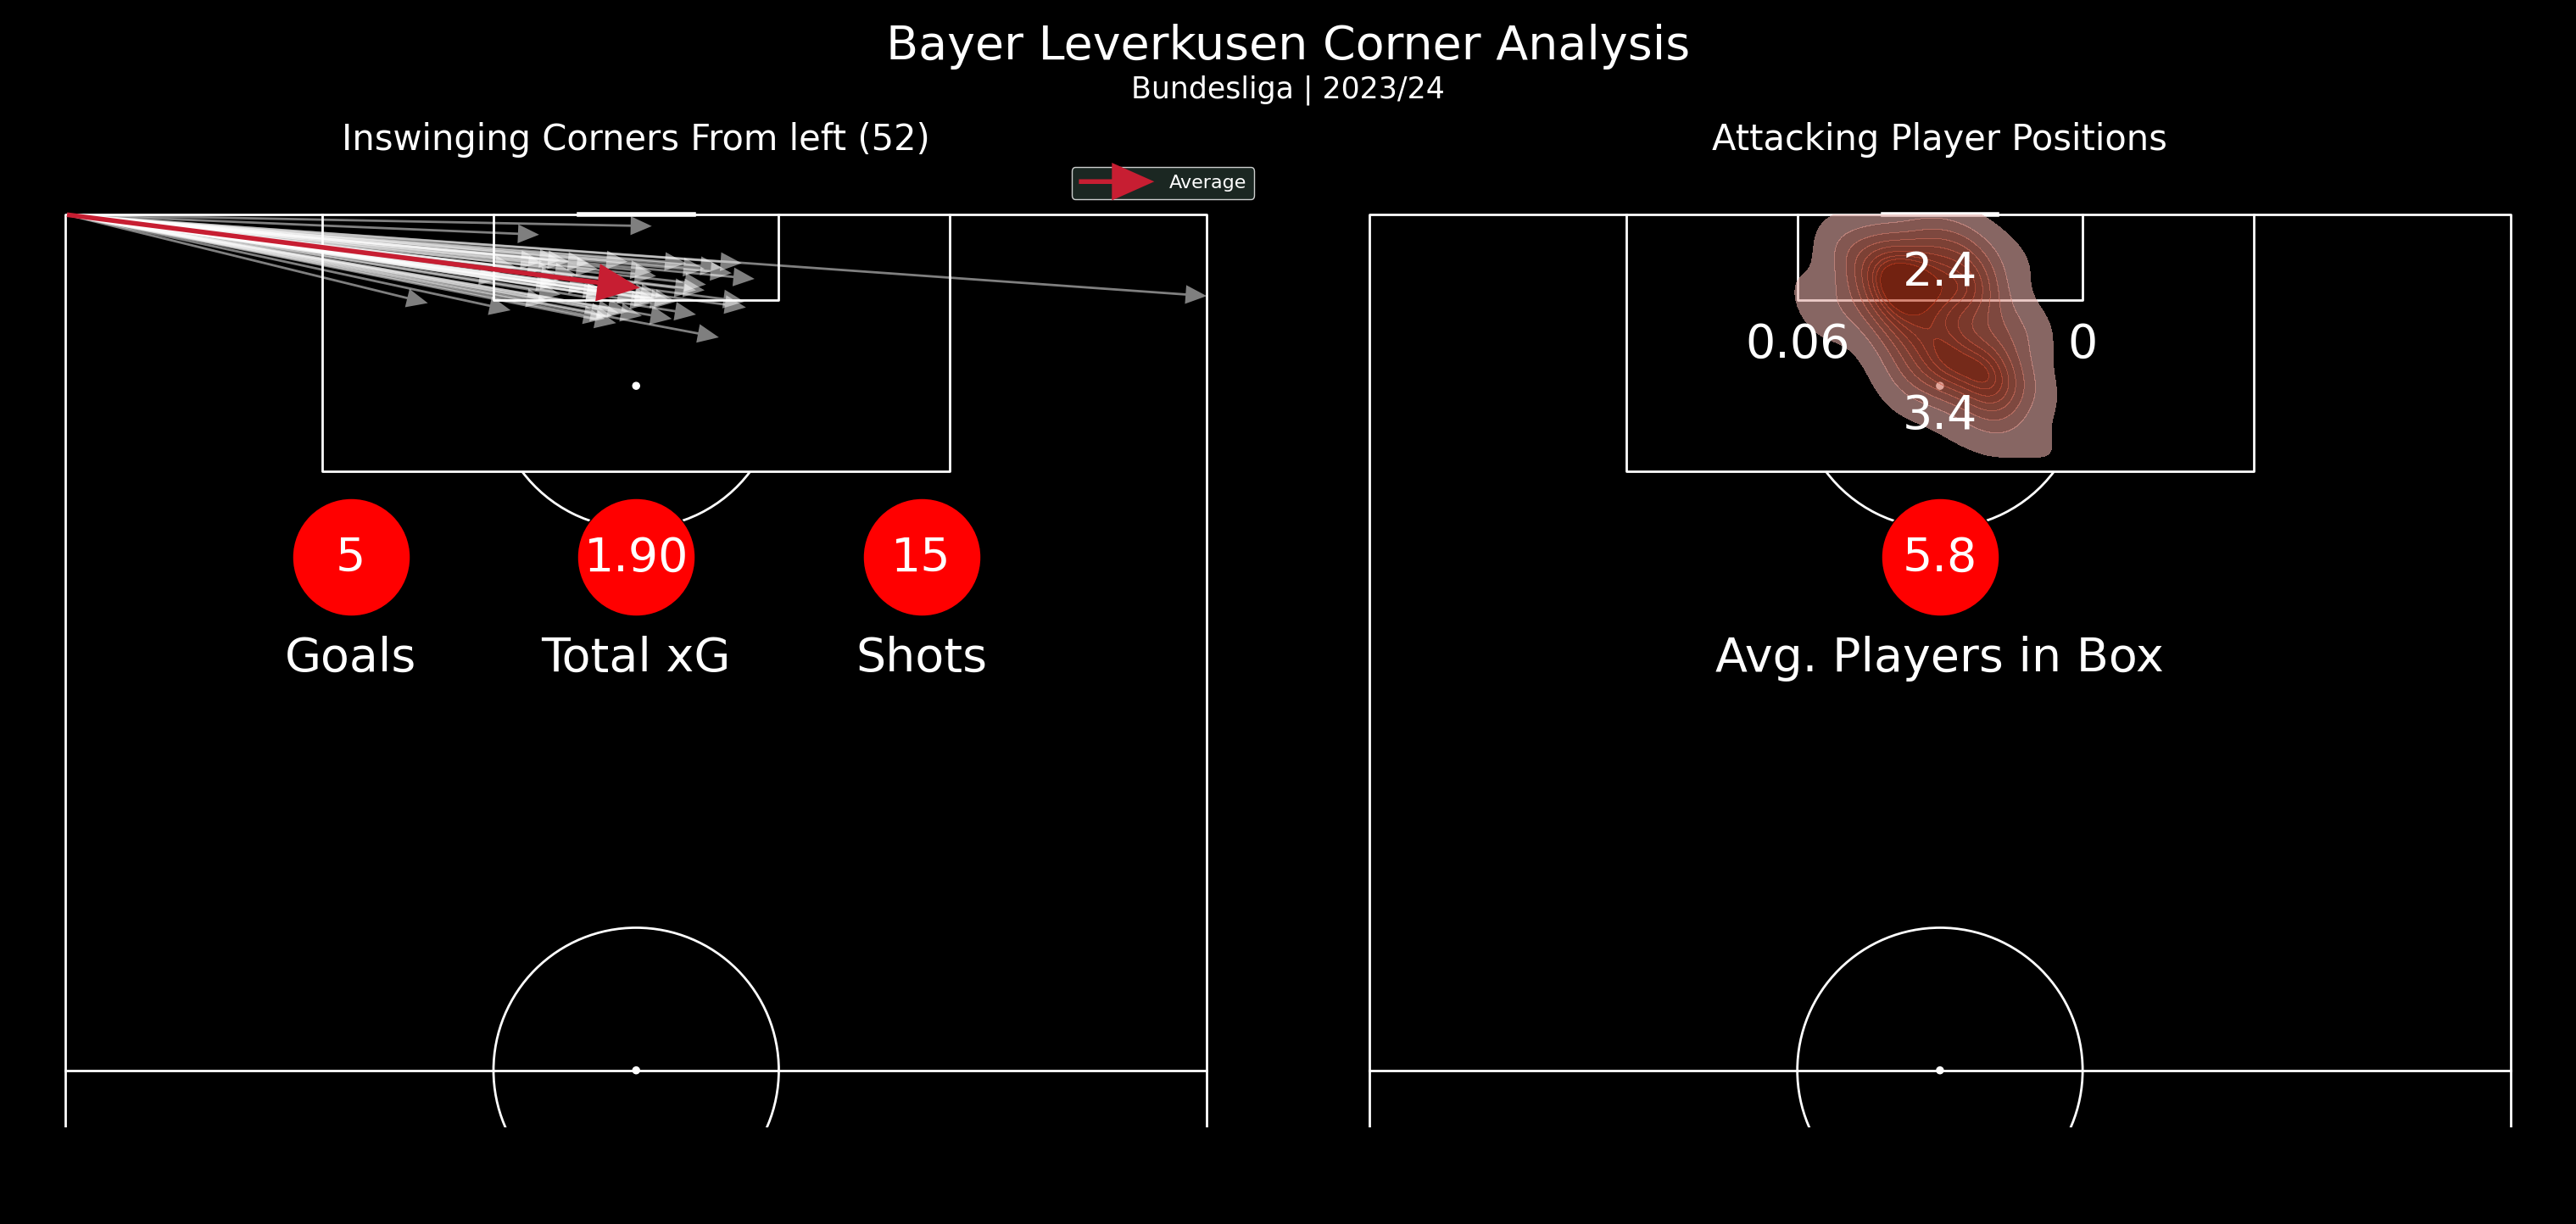

In [26]:
from matplotlib.colors import LinearSegmentedColormap
flamingo_cmap = LinearSegmentedColormap.from_list("Flamingo - 10 colors",
                                                  ['#e3aca7', '#c03a1d'], N=10)
pitch = VerticalPitch(half=True,pitch_type='statsbomb',pitch_color='#000000', line_color='white')
fig, axs = pitch.grid(ncols=2,figheight=16,title_height=0.08, title_space=0.03,endnote_space=0,axis=False)

fig.set_facecolor('#000000')

# title text
axs['title'].text(0.5, 0.65, 'Bayer Leverkusen Corner Analysis', fontsize=40,va='center', ha='center',color='white')
SUB_TEXT = ('Bundesliga | 2023/24')
axs['title'].text(0.5, 0.25, SUB_TEXT, fontsize=25,va='center', ha='center',color='white')

pitch.arrows(df_data.start_x, df_data.start_y,df_data.end_x,  df_data.end_y,angles='xy',color='white',
             ax=axs['pitch'][0], width=2, alpha=0.5,headwidth=8, headlength=9,headaxislength=9)

avg_x = df_data['end_x'].mean()
avg_y = df_data['end_y'].mean()

if side == 'left':
    x_avg = 120.0
    y_avg = 0.1
elif side == 'right':
    x_avg = 120.0
    y_avg = 80.0

pitch.arrows(x_avg, y_avg,avg_x, avg_y,color='#C71E32', ax=axs['pitch'][0], width=4, alpha=1,headwidth=8,headlength=9,headaxislength=9 , label='Average')

xg_created = df_data_shots['shot_statsbomb_xg'].sum()
xg_created_formatted = "{:.2f}".format(xg_created)
axs['pitch'][0].text(40,95,xg_created_formatted,fontsize=40,ha='center',color='white')
axs['pitch'][0].scatter(40,96,color='red',s=10000,edgecolors='black',linewidth=1)
axs['pitch'][0].text(40,88,'Total xG',fontsize=40,ha='center',color='white')

axs['pitch'][0].text(60,95,df_data_shots.shape[0],fontsize=40,ha='center',color='white')
axs['pitch'][0].scatter(60,96,color='red',s=10000,edgecolors='black',linewidth=1)
axs['pitch'][0].text(60,88,'Shots',fontsize=40,ha='center',color='white')

axs['pitch'][0].text(20,95,df_data_goals.shape[0],fontsize=40,ha='center',color='white')
axs['pitch'][0].scatter(20,96,color='red',s=10000,edgecolors='black',linewidth=1)
axs['pitch'][0].text(20,88,'Goals',fontsize=40,ha='center',color='white')

# Set up the legend
axs['pitch'][0].legend(facecolor='#22312b', handlelength=4, edgecolor='white', fontsize=16, loc='best',labelcolor='w')

ax_title = axs['pitch'][0].set_title(f"{swingtype} Corners From {side} ({df_data.shape[0]})", fontsize = 30,color='white')



df_temp = df_data_360[df_data_360['area'] != 'Out of Bounds']
pitch.kdeplot(df_temp.x, df_temp.y, ax=axs['pitch'][1], cmap=flamingo_cmap,fill=True,alpha=0.6)

ax_title = axs['pitch'][1].set_title('Attacking Player Positions', fontsize = 30,color='white')

average_players = round(df_temp['PlayerInBox'].mean(),1)
axs['pitch'][1].text(40,95,average_players,fontsize=40,ha='center',color='white')
axs['pitch'][1].scatter(40,96,color='red',s=10000,edgecolors='black',linewidth=1)
axs['pitch'][1].text(40,88,'Avg. Players in Box',fontsize=40,ha='center',color='white')

value_counts = df_temp['area'].value_counts()
# Calculate total number of observations
total_observations = df_temp.shape[0]

# Compute the average number of players for each specified area
avg_penaltyspot = round((value_counts.get('Penalty Spot', 0) / total_observations) * average_players, 1)
avg_firstpost = round((value_counts.get('First Post', 0) / total_observations) * average_players, 2)
avg_secondpost = round((value_counts.get('Second Post', 0) / total_observations) * average_players, 2)
avg_closetogoal = round((value_counts.get('Close to Goal', 0) / total_observations) * average_players, 1)

axs['pitch'][1].text(40,105,avg_penaltyspot,fontsize=40,ha='center',color='white')
axs['pitch'][1].text(30,110,avg_firstpost,fontsize=40,ha='center',color='white')
axs['pitch'][1].text(40,115,avg_closetogoal,fontsize=40,ha='center',color='white')
axs['pitch'][1].text(50,110,'0',fontsize=40,ha='center',color='white')

plt.savefig(f'C:/Users/acer/Desktop/IndianCityzen/Projects/Images/LeverkusenAnalysis/Corners/{side}_{swingtype}.png',dpi=500,bbox_inches = 'tight',facecolor='black')